# Leveraging BLIP for poor segmentation: demo

https://arxiv.org/html/2312.04539v1/

Some notebook links

 - [Setup](#Setup)

## Setup

Uncomment and run the following cell if you don't have Rust.

In [1]:
# # install Rust for HF tokenizers
# !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh

In [ ]:
%shell
if [ ! -d Segment-Everything-Everywhere-All-At-Once ] ; then
    git clone git@github.com:UX-Decoder/Segment-Everything-Everywhere-All-At-Once.git
fi

The following cell is for the X-Decoder model.

In [ ]:
%pip install -e Segment-Everything-Everywhere-All-At-Once

You can fast-forward to the `pip freeze` cell below and install the packages listed there.

In [4]:
%pip install -q torch-kmeans torcheval spacy crfseg nltk transformers==4.41.0 timm fairscale

Note: you may need to restart the kernel to use updated packages.


In [5]:
import nltk
nltk.download('wordnet', quiet=True)

True

In [6]:
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
!pip freeze

absl-py==2.1.0
accelerate==0.23.0
aiofiles==23.2.1
aiohttp==3.9.5
aiosignal==1.3.1
altair==5.3.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.4.0
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
awscrt==0.20.9
Babel==2.15.0
backoff==2.2.1
beautifulsoup4==4.12.3
black==21.4b2
bleach==6.1.0
blis==0.7.11
boto3==1.34.117
botocore==1.34.117
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2
cityscapesScripts==2.2.2
click==8.1.7
cloudpathlib==0.18.1
cloudpickle==3.0.0
coloredlogs==15.0.1
comm==0.2.2
confection==0.1.5
contourpy==1.2.1
crfseg==1.0.0
cycler==0.12.1
cymem==2.0.8
Cython==3.0.2
debugpy==1.8.1
decorator==5.1.1
deepspeed==0.10.3
defusedxml==0.7.1
detectron2 @ git+https://github.com/MaureenZOU/detectron2-xyz.git@42121d75e10d9f858f3a91b6a39f5722c02868f0
diffdist==0.1
dnspython==2.6.1
docker-pycreds==0.4.0
einops==0.7.0
email_valida

Imports

In [8]:
import math
import matplotlib
import matplotlib.patches
import matplotlib.pyplot as plt
import requests
import skimage.color.colorlabel
import torch
import torcheval
import torcheval.metrics
import torchvision

from dataclasses import dataclass
from PIL import Image
from skimage import color
from skimage import io
from textwrap import fill
from torch_kmeans import KMeans
from torchvision import transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
from typing import Dict, List, Tuple

Sample image

In [9]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
# http://images.cocodataset.org/val2017/000000039769.jpg
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

## Wprawka

### No model działa :)

Czy chcemy embeddować patche niezależnie, czy razem (chyba tak, bo mamy Multi-head attention).
Oczywiście, że razem

Text generation

In [10]:
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration

processor_s = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_s = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [11]:
# conditional image captioning
text = "a photography of"
inputs = processor_s(image, text, return_tensors="pt")

out = model_s.generate(**inputs)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)
# >>> a photography of a woman and her dog

# unconditional image captioning
inputs = processor_s(image, return_tensors="pt")

out = model_s.generate(**inputs)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)
# >>> a woman sitting on the beach with her dog

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a woman and her dog on the beach
a woman sitting on the beach with her dog


In [12]:
vision_outputs = model_s.vision_model.forward(
    pixel_values=inputs['pixel_values'],
    # pixel_mask=inputs['pixel_mask'],
    # return_dict=True
)
image_embeds = vision_outputs.last_hidden_state
image_embeds

tensor([[[-0.1773, -0.2170, -0.2945,  ...,  0.5116,  0.6934, -0.0700],
         [-1.0814,  0.2754, -0.2499,  ..., -1.4706,  0.0035, -0.0398],
         [-0.5621, -0.1927, -0.1502,  ..., -0.9316, -0.7027, -0.3139],
         ...,
         [ 0.3519, -0.0165, -0.0759,  ..., -0.1243, -0.0274, -0.7747],
         [-0.8698,  0.5471, -0.1587,  ..., -0.0307, -0.6847, -0.0901],
         [-0.5876,  0.5352, -0.5389,  ...,  0.0215, -0.0669, -0.3375]]],
       grad_fn=<NativeLayerNormBackward0>)

In [13]:
# no ciekawe, daliśmy wszystkie embeddingi i działa
out = model_s.text_decoder.generate(
    encoder_hidden_states=image_embeds,
    # encoder_outputs=image_embeds,
    # attention_mask=inputs['attention_mask'],
    # max_length=128,
    # num_beams=4,
    # early_stopping=True,
    # no_repeat_ngram_size=3,
    # num_return_sequences=1,
    # decoder_start_token_id=processor_s.tokenizer.pad_token_id
)
print(out)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[30522,  1037,  2450,  3564,  2006,  1996,  3509,  2007,  2014,  3899,
           102,   102,   102,   102,   102,   102,   102,   102,   102,   102]])
a woman sitting on the beach with her dog


In [14]:
KMeans(n_clusters=5)(torch.zeros(7)[None, :, None]).labels.unique().shape.numel()
# KMeans(n_clusters=5)(torch.zeros(7)[None, :, None]).centers

Full batch converged at iteration 1/100 with center shifts = tensor([0.]).


1

In [15]:
image_embeds.shape

torch.Size([1, 577, 768])

In [16]:
# bez tokenu CLS też daje radę
out = model_s.text_decoder.generate(
    encoder_hidden_states=image_embeds[:, 1:, :], # [bs, ntoken, hidden_state_size]
    # encoder_outputs=image_embeds,
    # attention_mask=inputs['attention_mask'],
    # max_length=128,
    # num_beams=4,
    # early_stopping=True,
    # no_repeat_ngram_size=3,
    # num_return_sequences=1,
    # decoder_start_token_id=processor_s.tokenizer.pad_token_id
)
print(out)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)

tensor([[30522,  1037,  2450,  3564,  2006,  1996,  3509,  2007,  2014,  3899,
           102,   102,   102,   102,   102,   102,   102,   102,   102,   102]])
a woman sitting on the beach with her dog


Tokens

In [17]:
out

tensor([[30522,  1037,  2450,  3564,  2006,  1996,  3509,  2007,  2014,  3899,
           102,   102,   102,   102,   102,   102,   102,   102,   102,   102]])

## Clustering

In [18]:
# Let's assume that the preprocessing is essentially the same for the base and large models
# and we can use the same processor for both, but we will create two for different image sizes
def get_models():
    processor_s = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model_s = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    processor_l = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", size={"height": 512, "width": 512}) # the altered size would also work with the small model
    model_l = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

    return processor_s, model_s, processor_l, model_l

In [19]:
processor_s, model_s, processor_l, model_l = get_models()

In [20]:
processor_s

BlipProcessor:
- image_processor: BlipImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[S

In [21]:
processor_l

BlipProcessor:
- image_processor: BlipImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  },
  "size_divisor": 32
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-large', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_token

In [22]:
@dataclass
class ClusterizationResult:
    # input_image: torch.Tensor
    ncluster: int
    cluster_label_assignments: torch.Tensor # for each pixel assign a cluster number # TODO rename to cluster_id_map # TODO rename label to id everywhere
    decoded_cluster_descriptions: List[str]

In [23]:
@torch.no_grad()
def get_kmeans_cluster_assignments(
    models: Dict[str, Tuple[BlipProcessor, BlipForConditionalGeneration]],
    image,
    ks=(2, 8)
) -> Dict[str, ClusterizationResult]:
    result = {}
    for model_processor_pair_name, (processor, blip) in models.items():
        for k in ks:
            print(f"{model_processor_pair_name}, {k=}")
            inputs = processor(image, return_tensors="pt")
            input_image_batch = inputs['pixel_values']

            # TODO see model.get_image_features
            vision_out = blip.vision_model(input_image_batch, return_dict=True, interpolate_pos_encoding=True) # important to interpolate the positional encoding! # TODO can we always do that?

            # seems we have 576 (24*24) or 1024 (32*32) patches
            image_embeds = vision_out.last_hidden_state[:, 1:, :] # [bs, num_patches, hidden_size]/[bs, 576, 768] # discard the hidden state for the CLS token

            kmeans = KMeans(n_clusters=k) #, distance='cosine') # worth trying cosine distance
            cluster_assignments = kmeans(image_embeds)

            ncluster = cluster_assignments.labels.unique().shape.numel()
            decoded_cluster_descriptions = []
            # for every cluster, apply the text decoder conditioned on the encoded patches
            # it somehow works, even if the patches are not consecutive
            for cluster in range(ncluster):
                cluster_patch_embeddings = image_embeds[:, cluster_assignments.labels[0] == cluster, :]
                # print(f"{cluster_patch_embeddings.shape=}")
                out = blip.text_decoder.generate(
                    encoder_hidden_states=cluster_patch_embeddings, # [bs, ntoken, hidden_state_size]
                    # encoder_outputs=image_embeds,
                    # attention_mask=inputs['attention_mask'],
                    # max_length=128,
                    # num_beams=4,
                    # early_stopping=True,
                    # no_repeat_ngram_size=3,
                    # num_return_sequences=1,
                    # decoder_start_token_id=processor.tokenizer.pad_token_id
                )
                text_output = processor.decode(out[0], skip_special_tokens=True)
                decoded_cluster_descriptions.append(text_output)
                print(f"{cluster=}, {text_output=}")

            # upscale the cluster assignment for the patches and reshape it to the original image resolution
            npatch = image_embeds.shape[1] # the shape is [bs, npatch, embedding_dim]
            patch_size = 16 # let's just assume that this is what we have in the model instead of passing this as a parameter that would never be changed
            image_size_in_patches = int(math.sqrt(npatch)) # 24 for the small model (24x24 16x16 patches gives 384x384 image size)
            upscaled_cluster_assignments = cluster_assignments.labels.view(image_size_in_patches, image_size_in_patches).repeat_interleave(patch_size, 0).repeat_interleave(patch_size, 1)

            result[f"{model_processor_pair_name}, {k=}"] = ClusterizationResult(
                ncluster,
                upscaled_cluster_assignments,
                decoded_cluster_descriptions
            )
    return result

In [24]:
def visualize_clusters(original_input_image: Image.Image, pixel_cluster_assignments: Dict[str, ClusterizationResult]):
    plot_ncol = 2
    plot_nrow = math.ceil(len(pixel_cluster_assignments) / plot_ncol)
    plot_size = 7
    plt.figure(figsize=(plot_size * plot_ncol, plot_size * 1.75 * plot_nrow))

    plt.title("Cluster assignments for different model sizes, image sizes and number of clusters", pad=(plot_size * 7))
    plt.axis('off')

    for i, (cluster_assignment_title, cluster_assignment) in enumerate(pixel_cluster_assignments.items()):

        height, width = cluster_assignment.cluster_label_assignments.shape
        # the label map sizes are not uniform, we need to scale images, so both can be plotted together
        scaled_input_image = transforms.functional.pil_to_tensor(
            transforms.functional.resize(original_input_image, (height, width))
            ).permute(1, 2, 0).numpy()

        ax = plt.subplot2grid((plot_nrow, plot_ncol), (i// plot_ncol, i % plot_ncol))
        ax.axis('off')
        ax.set_title(cluster_assignment_title)
        ax.imshow(color.label2rgb(cluster_assignment.cluster_label_assignments.numpy(), scaled_input_image, bg_label=666)) # there's no background label (yet ;))

        legend_patches = [
            matplotlib.patches.Patch(color=c, label=fill(text, width=60))
            for c, text in zip(color.colorlabel.DEFAULT_COLORS, cluster_assignment.decoded_cluster_descriptions)
        ]
        plt.legend(handles=legend_patches, bbox_to_anchor=(0.5, -0.05), loc='upper center', borderaxespad=0., fontsize='small')

        #     loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #   fancybox=True, shadow=True, ncol=5)
    

    plt.tight_layout()
    # plt.tight_layout(pad=1.0, h_pad=5.0)
    plt.show()

In [25]:
color.colorlabel.DEFAULT_COLORS

('red',
 'blue',
 'yellow',
 'magenta',
 'green',
 'indigo',
 'darkorange',
 'cyan',
 'pink',
 'yellowgreen')

small model, 384x384 image, k=2


Full batch converged at iteration 16/100 with center shifts = tensor([0.]).
cluster=0, text_output='a woman sitting on the ground with a dog'
cluster=1, text_output='beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach'
small model, 384x384 image, k=8
Full batch converged at iteration 28/100 with center shifts = tensor([0.]).
cluster=0, text_output='the sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset'
cluster=1, text_output='a white background with a black and white image of a white background with a black and white image'
cluster=2, text_output='a woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman'
cluster=3, text_output='a a a a a a a a a a a a a a a a a a a'
cluster=4, text_output='the waves waves waves waves waves waves waves waves waves waves waves waves waves waves waves waves waves wave

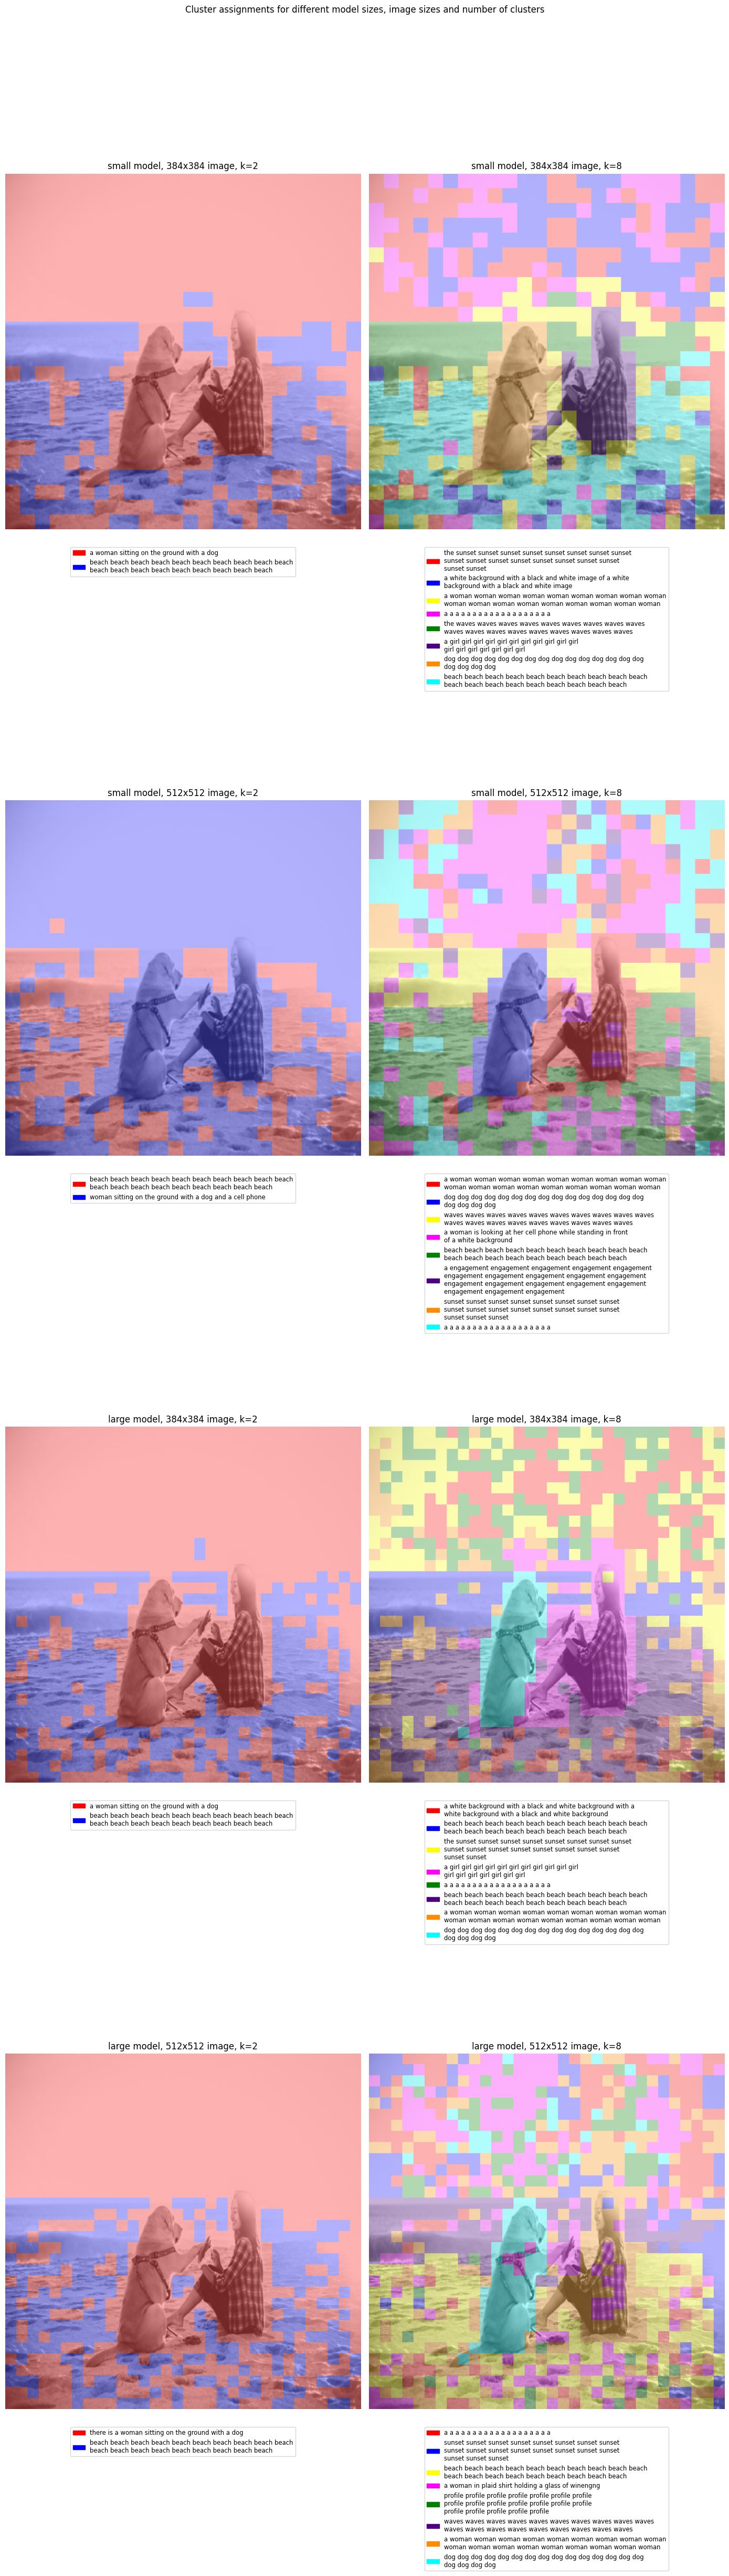

In [26]:
models = {
    'small model, 384x384 image': (processor_s, model_s),
    'small model, 512x512 image': (processor_s, model_l),
    'large model, 384x384 image': (processor_l, model_s),
    'large model, 512x512 image': (processor_l, model_l),
}
cluster_data = get_kmeans_cluster_assignments(
    models,
    image,
    ks=(2, 8)
)
visualize_clusters(image, cluster_data)

## Alignment

In [27]:
print(*cluster_data.keys(), sep='\n')

small model, 384x384 image, k=2
small model, 384x384 image, k=8
small model, 512x512 image, k=2
small model, 512x512 image, k=8
large model, 384x384 image, k=2
large model, 384x384 image, k=8
large model, 512x512 image, k=2
large model, 512x512 image, k=8


In [28]:
target = cluster_data['small model, 384x384 image, k=8']
input = cluster_data['small model, 512x512 image, k=2']
confusion_matrix = torcheval.metrics.functional.multiclass_confusion_matrix(
    target=target.cluster_label_assignments.flatten(), # ten co ma najwięcej
    input=input.cluster_label_assignments.flatten(),
    # torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    # torch.tensor([0, 0, 2, 3, 4, 5, 6, 7, 8, 9]),
    num_classes=cluster_data['small model, 384x384 image, k=8'].ncluster,
    # normalize=''
    # normalize='all'
)
# iou = confusion_matrix

In [29]:
confusion_matrix

tensor([[ 2816, 24064,     0,     0,     0,     0,     0,     0],
        [ 2560, 21760,     0,     0,     0,     0,     0,     0],
        [ 2304, 16896,     0,     0,     0,     0,     0,     0],
        [  768, 17152,     0,     0,     0,     0,     0,     0],
        [ 9728,  2816,     0,     0,     0,     0,     0,     0],
        [    0,  9728,     0,     0,     0,     0,     0,     0],
        [    0, 10240,     0,     0,     0,     0,     0,     0],
        [17664,  8960,     0,     0,     0,     0,     0,     0]])

In [30]:
reference_cluster_assignment = confusion_matrix.argmax(dim=0)[:input.ncluster]

In [31]:
# iou = confusion_matrix.diagonal().sum()
# iou

In [32]:
cluster_data['small model, 384x384 image, k=2'].cluster_label_assignments

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [33]:
pixel_cluster_assignments: Dict[str, ClusterizationResult]

In [34]:
def hungarian_matching_cluster_alignment(reference_cluster_map: torch.Tensor, reference_cluster_set_ncluster: int, c_cluster_map: torch.Tensor, c_cluster_set_ncluster: int) -> torch.Tensor:
    """Assigns the input clusters to the reference clusters."""
    confusion_matrix = torcheval.metrics.functional.multiclass_confusion_matrix(
        target=reference_cluster_map.flatten(),
        input=c_cluster_map.flatten(),
        num_classes=reference_cluster_set_ncluster,
    )
    reference_cluster_assignment = confusion_matrix.argmax(dim=0)[:c_cluster_set_ncluster]

    return reference_cluster_assignment

In [35]:
hungarian_matching_cluster_alignment(
    cluster_data['small model, 384x384 image, k=8'].cluster_label_assignments,
    cluster_data['small model, 384x384 image, k=8'].ncluster,
    cluster_data['small model, 512x512 image, k=2'].cluster_label_assignments,
    cluster_data['small model, 512x512 image, k=2'].ncluster,
)

tensor([7, 0])

In [36]:
def upscale_cluster_label_assignment_maps(cluster_label_assignments: Dict[str, ClusterizationResult]) -> Dict[str, ClusterizationResult]:
    """Upscales the cluster label assignment maps from (32*16)x(32*16) or (24*16)x(24*16) to (96*16)x(96*16) for subsequent Hungarian matching call."""
    # upscale all the maps to the same resolution
    for cluster_assignment in cluster_label_assignments.values():
        map_height, map_width = cluster_assignment.cluster_label_assignments.shape
        print(f"{map_height=}, {map_width=}")
        if map_height == 384 and map_width == 384:
            copy_times = 96 // 24 # 4
        elif map_height == 512 and map_width == 512:
            copy_times = 96 // 32 # 3
        else:
            raise ValueError(f"Unexpected cluster label map shape: {map_height=}, {map_width=}")
        upscaled_map = cluster_assignment.cluster_label_assignments.repeat_interleave(copy_times, 0).repeat_interleave(copy_times, 1)
        cluster_assignment.cluster_label_assignments = upscaled_map
            # min_height, min_width = 96, 96
    #     cluster_assignment.cluster_label_assignments = transforms.functional.resize(
    #         cluster_assignment.cluster_label_assignments[None, None, :, :].float(),
    #         (min_height, min_width),
    #         mode='nearest'
    #     ).squeeze().long()
    return cluster_label_assignments # not really needed, as we modify it in place now

In [37]:
upscale_cluster_label_assignment_maps(cluster_data)

map_height=384, map_width=384
map_height=384, map_width=384
map_height=384, map_width=384
map_height=384, map_width=384
map_height=512, map_width=512
map_height=512, map_width=512
map_height=512, map_width=512
map_height=512, map_width=512


{'small model, 384x384 image, k=2': ClusterizationResult(ncluster=2, cluster_label_assignments=tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), decoded_cluster_descriptions=['a woman sitting on the ground with a dog', 'beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach']),
 'small model, 384x384 image, k=8': ClusterizationResult(ncluster=8, cluster_label_assignments=tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [3, 3, 3,  ..., 2, 2, 2],
         [3, 3, 3,  ..., 2, 2, 2],
         [3, 3, 3,  ..., 2, 2, 2]]), decoded_cluster_descriptions=['the sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset', 'a w

In [38]:
reference_set_name: str = max(cluster_data.keys(), key=lambda x: cluster_data[x].ncluster)
# reference_cluster_set = cluster_data[reference_set_name]

In [39]:
def calculate_cluster_confidence(cluster_data: Dict[str, ClusterizationResult], reference_set_name: str) -> torch.Tensor:
    """The returned value is actually a segmentation mask"""
    reference_cluster_set = cluster_data[reference_set_name]
    c_cluster_set_names = [model_name for model_name in cluster_data if model_name != reference_set_name]

    # reference_cluster_masks = {c: [] for c in range(reference_cluster_set.ncluster)}
    reference_cluster_masks = torch.zeros(reference_cluster_set.ncluster, *reference_cluster_set.cluster_label_assignments.shape)

    # for every reference cluster, how many masks from other cluster assignments contribute to the final mask; will be used for averaging the contributing masks
    n_contributing_masks = torch.zeros(reference_cluster_set.ncluster)

    for c_cluster_set_name in c_cluster_set_names:
        c_cluster_set = cluster_data[c_cluster_set_name]

        # print(f"{reference_cluster_set.cluster_label_assignments.shape=}")
        # print(f"{c_cluster_set.cluster_label_assignments.shape=}")

        reference_cluster_assignment = hungarian_matching_cluster_alignment(
            reference_cluster_set.cluster_label_assignments,
            reference_cluster_set.ncluster,
            c_cluster_set.cluster_label_assignments,
            c_cluster_set.ncluster
        )

        n_contributing_masks[reference_cluster_assignment] += 1 # if a cluster was assigned, it contributes to the final mask and we count it now

        # print(f"{reference_cluster_assignment=}")

        original_c_pixel_labels = c_cluster_set.cluster_label_assignments
        # c_mask_new_pixel_labels = 
        # print(f"{original_c_pixel_labels.shape=}")

        c_masks_before_relabelling = original_c_pixel_labels[None, :, :] == torch.arange(c_cluster_set.ncluster)[:, None, None]

        reference_cluster_masks[reference_cluster_assignment] += c_masks_before_relabelling.float()
        
        # print(f"{c_masks_before_relabelling.shape=}")
        # print(f"{c_masks_before_relabelling=}")

        # c_masks_

        # reference_cluster_masks.append(
        # )
        # print(torch.arange(c_cluster_set.ncluster)[:, None])
        # print(reference_cluster_masks[-1].shape)
        # break

        # # calculate the intersection over union
        # confusion_matrix = torcheval.metrics.functional.multiclass_confusion_matrix(
        #     target=reference_cluster_set.cluster_label_assignments.flatten(),
        #     input=c_cluster_set.cluster_label_assignments.flatten(),
        #     num_classes=reference_cluster_set.ncluster,
        # )
        # iou = confusion_matrix[reference_cluster_assignment, torch.arange(c_cluster_set.ncluster)].float().sum() / (confusion_matrix.sum(dim=0) + confusion_matrix.sum(dim=1) - confusion_matrix[reference_cluster_assignment, torch.arange(c_cluster_set.ncluster)].float()).clamp(min=1e-6)

        # calculate the confidence of the
    
    # reference_cluster_masks = torch.mean(torch.stack(reference_cluster_masks, dim=0).float(), dim=0)
    # print(f"{n_contributing_masks=}")
    reference_cluster_masks /= n_contributing_masks[:, None, None]
    return reference_cluster_masks

In [40]:
# L in the paper
reference_cluster_confidence = calculate_cluster_confidence(cluster_data, reference_set_name)
reference_cluster_confidence.shape

torch.Size([8, 1536, 1536])

In [41]:
def visualize_reference_cluster_confidence( # todo rename to visualize_reference_cluster_set_confidence
    reference_cluster_confidence: torch.Tensor,
    original_input_image: Image.Image,
    cluster_data: Dict[str, ClusterizationResult],
    reference_set_name: str
):
    mask_height, mask_width = reference_cluster_confidence.shape[-2:]

    ncluster = reference_cluster_confidence.shape[0]
    plot_ncol = 2
    plot_nrow = ncluster
    plot_size = 7

    plt.figure(figsize=(plot_size * plot_ncol, plot_size * 1.5 * plot_nrow))

    plt.title("Confidence mask for clusters of the reference cluster assignment")
    plt.axis('off')

    for i, decoded_cluster_description in enumerate(cluster_data[reference_set_name].decoded_cluster_descriptions):
        # plt.subplot(1, reference_cluster_confidence.shape[0], i + 1)
        # plt.imshow(
        #     transforms.functional.to_pil_image(
        #         reference_cluster_confidence[i, :, :]
        #     )
        # )
        ith_cluster_confidence = reference_cluster_confidence[i]
        # print(f"{ith_cluster_confidence.shape=}")
        # print(f"{transforms.functional.pil_to_tensor(transforms.functional.resize(original_input_image, (mask_height, mask_width))).shape=}")
        # print(f"{transforms.functional.pil_to_tensor(transforms.functional.resize(original_input_image, (mask_height, mask_width))).max()=}")

        ax = plt.subplot2grid((plot_nrow, plot_ncol), (i, 0))
        ax.axis('off')
        ax.set_title(fill(f"Cluster {i} visualization, decoded description: \"{decoded_cluster_description}\"", width=60))

        ax.imshow(
            # transforms.functional.to_pil_image(
            #     ith_cluster_confidence[None, :, :].repeat(3, 1, 1)
            # )
            # ith_cluster_confidence[None, :, :].permute(2, 1, 0)
            (
                (ith_cluster_confidence) *
                transforms.functional.pil_to_tensor(
                    transforms.functional.resize(original_input_image, (mask_height, mask_width))
                ) / 255 + (1.0 - ith_cluster_confidence[None, :, :])
            ).permute(1, 2, 0)
        )

        ax = plt.subplot2grid((plot_nrow, plot_ncol), (i, 1))
        ax.axis('off')

        ax.set_title(f"Cluster {i} confidence mask")
        ax.imshow(
            ith_cluster_confidence # [None, :, :].repeat(3, 1, 1)
        )

        
    plt.tight_layout()
    plt.show()

        # torchvision.utils.draw_segmentation_masks(
        #     image=transforms.functional.pil_to_tensor(
        #         transforms.functional.resize(original_input_image, (mask_height, mask_width))
        #         ),
        #     masks=reference_cluster_confidence)

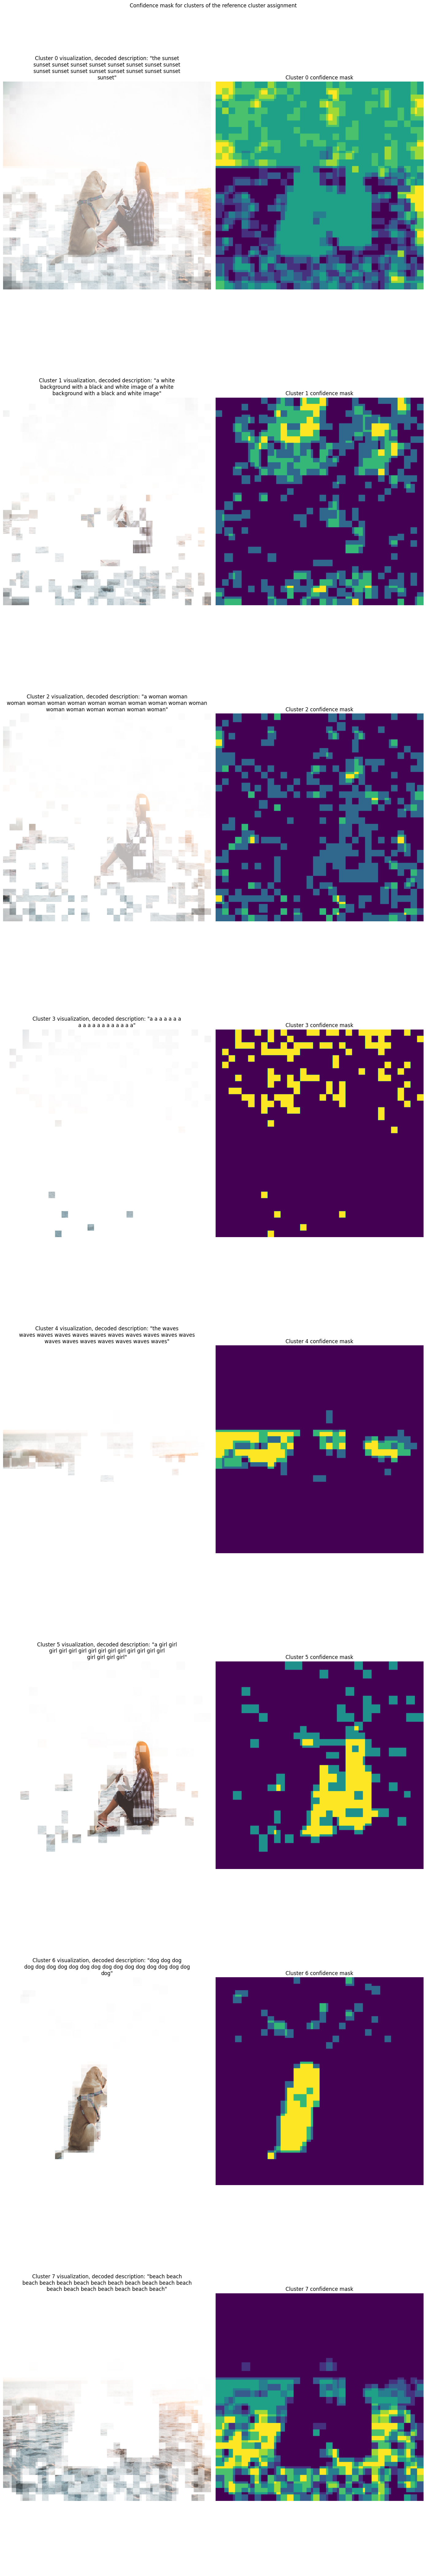

In [42]:
visualize_reference_cluster_confidence(
    reference_cluster_confidence,
    image,
    cluster_data,
    reference_set_name
)

In [43]:
# import crfseg

In [44]:
# visualize_reference_cluster_confidence(
#     reference_cluster_confidence,
#     image,
#     cluster_data,
#     reference_set_name
# )

In [45]:
reference_cluster_confidence.shape

torch.Size([8, 1536, 1536])

In [46]:
from crfseg import CRF

In [47]:
with torch.no_grad():
    crf_denoised_masks_cluster_masks = CRF(n_spatial_dims=2, returns='proba').forward(reference_cluster_confidence.unsqueeze(0))
    crf_denoised_masks_cluster_masks.shape

In [48]:
def visualise_crf_denoised_masks(
    crf_denoised_masks: torch.Tensor,
    original_input_image: Image.Image,
    cluster_data: Dict[str, ClusterizationResult],
    reference_set_name: str
):
    mask_height, mask_width = crf_denoised_masks.shape[-2:]

    ncluster = crf_denoised_masks.shape[0]
    plot_ncol = 2
    plot_nrow = ncluster
    plot_size = 7

    plt.figure(figsize=(plot_size * plot_ncol, plot_size * 1.5 * plot_nrow))

    plt.title("CRF denoised masks for clusters of the reference cluster assignment")
    plt.axis('off')

    for i, decoded_cluster_description in enumerate(cluster_data[reference_set_name].decoded_cluster_descriptions):
        ith_cluster_mask = crf_denoised_masks[i]
        # print(f"{ith_cluster_mask.shape=}")
        # print(f"{transforms.functional.pil_to_tensor(transforms.functional.resize(original_input_image, (mask_height, mask_width))).shape=}")
        # print(f"{transforms.functional.pil_to_tensor(transforms.functional.resize(original_input_image, (mask_height, mask_width))).max()=}")

        ax = plt.subplot2grid((plot_nrow, plot_ncol), (i, 0))
        ax.axis('off')
        ax.set_title(fill(f"Cluster {i} visualization, decoded description: \"{decoded_cluster_description}\"", width=60))

        ax.imshow(
            (
                (ith_cluster_mask) *
                transforms.functional.pil_to_tensor(
                    transforms.functional.resize(original_input_image, (mask_height, mask_width))
                ) / 255 + (1.0 - ith_cluster_mask[None, :, :])
            ).permute(1, 2, 0)
        )

        ax = plt.subplot2grid((plot_nrow, plot_ncol), (i, 1))
        ax.axis('off')

        ax.set_title(f"Cluster {i} CRF denoised mask")
        ax.imshow(
            ith_cluster_mask # [None, :, :].repeat(3, 1, 1)
        )

    plt.tight_layout()
    plt.show()

Czekaj, czy oni chcą, żebyśmy to zdyskretyzowali to 0/1?

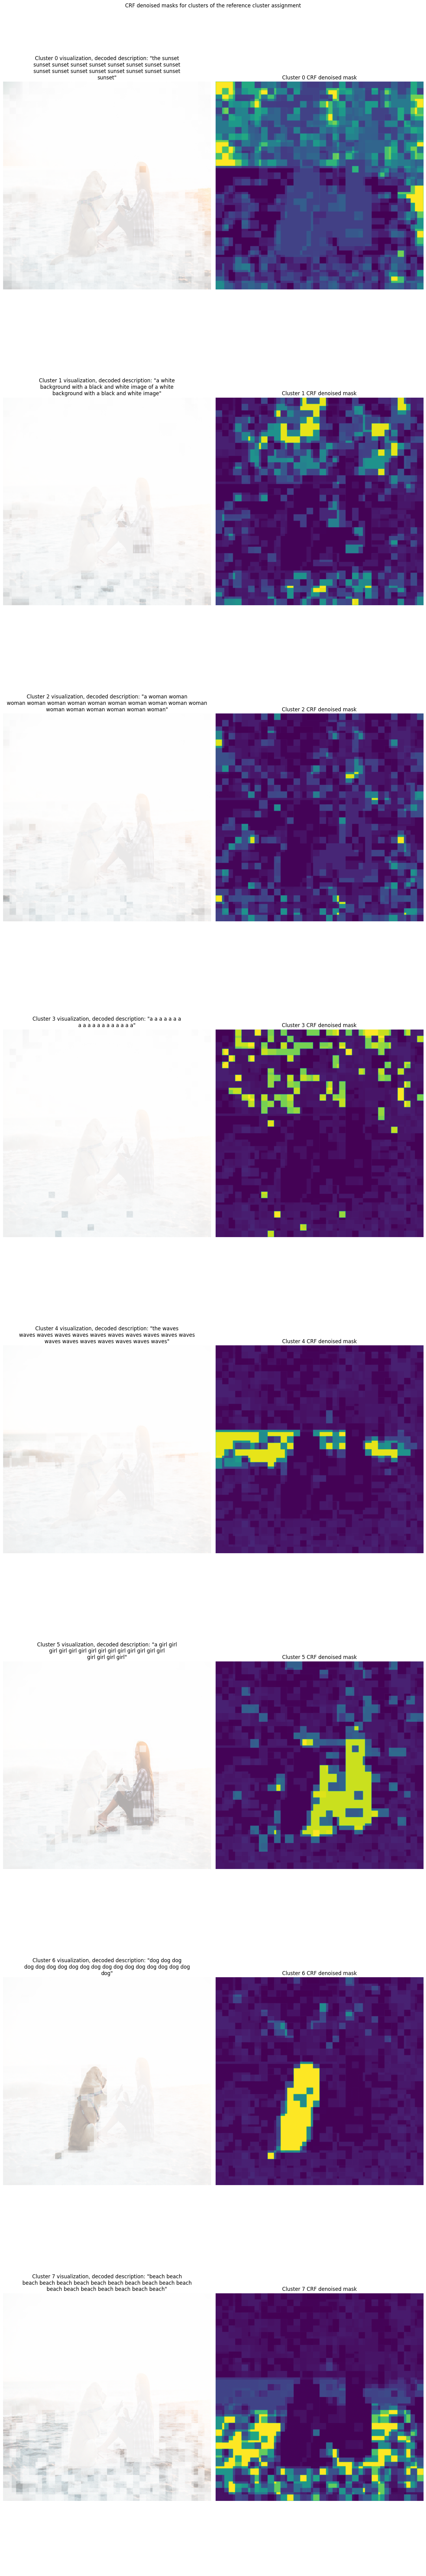

In [49]:
visualise_crf_denoised_masks(
    crf_denoised_masks_cluster_masks.squeeze(),
    image,
    cluster_data,
    reference_set_name
)

### Denoising (cont.)

In [50]:
# this is not entirely equivalent to what we have in the paper
def generate_majority_filter_cluster_map_for_patches(
    cluster_confidence_masks: torch.Tensor,
    reference_cluster_model_resolution # 384 or 512
) -> torch.Tensor:
    """Applies the majority filter to the cluster masks. What we want to get is the index of the most frequent cluster in the neighbourhood."""
    
    # ncluster = cluster_confidence_masks.shape[0]
    if reference_cluster_model_resolution == 384: # we want to get majority vote for every 16x16 patch in 384x384 image
        # kernel_size = 16
        conv_output = torch.nn.functional.avg_pool2d(
            input=cluster_confidence_masks,
            # input=cluster_confidence_masks.unsqueeze(0),
            # weight=torch.ones(ncluster, ncluster, kernel_size, kernel_size),
            kernel_size=64,
            stride=64,
            # padding=1, # equivalent to padding='same' for conv2d
            # padding='same'
        )
    elif reference_cluster_model_resolution == 512: # we want to get majority vote for every 16x16 patch in 512x512 image
        # kernel_size = 32
        conv_output = torch.nn.functional.avg_pool2d(
            input=cluster_confidence_masks,
            # input=cluster_confidence_masks.unsqueeze(0),
            # weight=torch.ones(ncluster, ncluster, kernel_size, kernel_size),
            kernel_size=48,
            stride=48,
            # padding=1, # equivalent to padding='same' for conv2d
            # padding='same'
        )
    patch_size = 16
    dest_resolution_in_patches = reference_cluster_model_resolution // patch_size
    dest_resolution_in_patches = (dest_resolution_in_patches, dest_resolution_in_patches)
    assert dest_resolution_in_patches == conv_output.shape[-2:], f"{dest_resolution_in_patches=} {conv_output.shape[-2:]=} are not equal"

    majority_vote = conv_output.argmax(dim=-3)
    assert dest_resolution_in_patches == majority_vote.shape[-2:], f"{dest_resolution_in_patches=} {majority_vote.shape[-2:]=} are not equal"
    return majority_vote

    # old, without changing the resolution
    # this would be equivalent to the paper if the input had the same size as the output we want to get (384x384 or 512x512 digestible by the model)
    # ncluster = cluster_confidence_masks.shape[0]
    # conv_output = torch.nn.functional.avg_pool2d(
    #     input=cluster_confidence_masks,
    #     # input=cluster_confidence_masks.unsqueeze(0),
    #     # weight=torch.ones(ncluster, ncluster, kernel_size, kernel_size),
    #     kernel_size=3,
    #     stride=1,
    #     padding=1, # equivalent to padding='same' for conv2d
    #     # padding='same'
    # )
    # assert cluster_confidence_masks.shape == conv_output.shape, f"{cluster_confidence_masks.shape=} {conv_output.shape=} are not equal"

    # majority_vote = conv_output.argmax(dim=-3)
    # assert cluster_confidence_masks.shape[-2:] == majority_vote.shape[-2:], f"{cluster_confidence_masks.shape[-2:]=} {majority_vote.shape[-2:]=} are not equal"
    # return majority_vote
    

In [51]:
test_data = torch.rand(3, 1536, 1536)

In [52]:
print(f"{test_data=}")
print(f"{test_data.shape=}")

test_data=tensor([[[0.6557, 0.1338, 0.5751,  ..., 0.6275, 0.1507, 0.2140],
         [0.1862, 0.8225, 0.9489,  ..., 0.0507, 0.9770, 0.7390],
         [0.1231, 0.9104, 0.3381,  ..., 0.1278, 0.3865, 0.4385],
         ...,
         [0.5935, 0.2982, 0.0650,  ..., 0.8623, 0.7748, 0.6794],
         [0.7556, 0.4661, 0.5553,  ..., 0.5524, 0.6728, 0.9595],
         [0.9382, 0.0023, 0.1474,  ..., 0.2536, 0.7617, 0.8971]],

        [[0.3962, 0.2378, 0.2910,  ..., 0.0499, 0.8450, 0.8660],
         [0.2929, 0.1110, 0.2499,  ..., 0.7158, 0.8069, 0.4923],
         [0.5975, 0.3421, 0.1339,  ..., 0.1772, 0.3771, 0.8879],
         ...,
         [0.0034, 0.1795, 0.5225,  ..., 0.2980, 0.4257, 0.3694],
         [0.9152, 0.3712, 0.6348,  ..., 0.2774, 0.4555, 0.8344],
         [0.5459, 0.4239, 0.5939,  ..., 0.3201, 0.8683, 0.0300]],

        [[0.8552, 0.8482, 0.6973,  ..., 0.4664, 0.7851, 0.3748],
         [0.8305, 0.2649, 0.1259,  ..., 0.5879, 0.7779, 0.7382],
         [0.9279, 0.5290, 0.0650,  ..., 0.5937, 

In [53]:
generate_majority_filter_cluster_map_for_patches(
    test_data,
    512
).shape

torch.Size([32, 32])

In [54]:
# generate_majority_filter_cluster_map_for_patches(
#     crf_denoised_masks_cluster_masks.squeeze()
# )

In [55]:
reference_set_name

'small model, 384x384 image, k=8'

In [56]:
majority_filter_denoised_cluster_label_map = generate_majority_filter_cluster_map_for_patches(
    crf_denoised_masks_cluster_masks.squeeze(),
    reference_cluster_model_resolution=(512 if '512' in reference_set_name else 384)
)

In [57]:
# majority_filter_denoised_cluster_label_map

In [58]:
majority_filter_denoised_cluster_label_map.shape

torch.Size([24, 24])

In [59]:
# crf_denoised_masks_cluster_masks.squeeze().shape

In [60]:
# TODO this has nothing to do with denoising
def decode_denoised_cluster_label_map(
    models: Dict[str, Tuple[BlipProcessor, BlipForConditionalGeneration]],
    denoised_cluster_label_map: torch.Tensor,
    # cluster_data: Dict[str, ClusterizationResult],
    reference_set_name: str,
    original_input_image
) -> List[str]:
    """Recreates cluster descriptions after the patches were reassigned to each cluster during cluster assignment denoising."""
    # well it may be that some cluster is removed during denoising
    cluster_ids = denoised_cluster_label_map.unique().tolist()

    processor, blip = [
        model_processor
        for model_processor_pair_name, model_processor in models.items()
        if reference_set_name.startswith(model_processor_pair_name)][0]
    
    print(f"{cluster_ids=}")

    inputs = processor(original_input_image, return_tensors="pt")
    input_image_batch = inputs['pixel_values']
    vision_out = blip.vision_model(input_image_batch, return_dict=True, interpolate_pos_encoding=True) # important to interpolate the positional encoding! # TODO can we always do that?
    image_embeds = vision_out.last_hidden_state[:, 1:, :] # [bs, num_patches, hidden_size]/[bs, 576, 768] # discard the hidden state for the CLS token
    decoded_cluster_descriptions = []

    print(f"{image_embeds.shape=}")
    print(f"{denoised_cluster_label_map.shape=}")

    for cluster_id in cluster_ids:
        cluster_patch_embeddings = image_embeds[:, denoised_cluster_label_map.flatten() == cluster_id, :] # todo this flatten assumes there's no batch dimension
        # print(f"{cluster_patch_embeddings.shape=}")
        out = blip.text_decoder.generate(
            encoder_hidden_states=cluster_patch_embeddings, # [bs, ntoken, hidden_state_size]
            # encoder_outputs=image_embeds,
            # attention_mask=inputs['attention_mask'],
            # max_length=128,
            # num_beams=4,
            # early_stopping=True,
            # no_repeat_ngram_size=3,
            # num_return_sequences=1,
            # decoder_start_token_id=processor.tokenizer.pad_token_id
        )
        text_output = processor.decode(out[0], skip_special_tokens=True)
        decoded_cluster_descriptions.append(text_output)
        print(f"{cluster_id=}, {text_output=}")
    # decoded_cluster_descriptions = []
    # for i, decoded_cluster_description in enumerate(cluster_data[reference_set_name].decoded_cluster_descriptions):
    #     decoded_cluster_descriptions.append(decoded_cluster_description)
    return decoded_cluster_descriptions

In [61]:
decoded_denoised_cluster_descriptions = decode_denoised_cluster_label_map(
    models,
    majority_filter_denoised_cluster_label_map,
    # cluster_data,
    reference_set_name,
    image
)
decoded_denoised_cluster_descriptions

cluster_ids=[0, 1, 2, 3, 4, 5, 6, 7]
image_embeds.shape=torch.Size([1, 576, 768])
denoised_cluster_label_map.shape=torch.Size([24, 24])


cluster_id=0, text_output='a woman sitting on the beach at sunset'
cluster_id=1, text_output='a woman sitting on the beach with her cell'
cluster_id=2, text_output='a beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach'
cluster_id=3, text_output='a a a a a a a a a a a a a a a a a a a'
cluster_id=4, text_output='a beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach'
cluster_id=5, text_output='a girl girl girl girl girl girl girl girl girl girl girl girl girl girl girl girl girl girl'
cluster_id=6, text_output='a dog and a dog sit together with a dog and a golden golden retrieve'
cluster_id=7, text_output='a beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach'


['a woman sitting on the beach at sunset',
 'a woman sitting on the beach with her cell',
 'a beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach',
 'a a a a a a a a a a a a a a a a a a a',
 'a beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach',
 'a girl girl girl girl girl girl girl girl girl girl girl girl girl girl girl girl girl girl',
 'a dog and a dog sit together with a dog and a golden golden retrieve',
 'a beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach']

In [62]:
def visualize_denoised_patch_clusters(
    denoised_cluster_label_map: torch.Tensor,
    decoded_cluster_descriptions: List[str],
    original_input_image: Image.Image,
    reference_set_name
):
    height_in_patches, width_in_patches = denoised_cluster_label_map.shape
    patch_size = 16

    upsampled_label_map = denoised_cluster_label_map.repeat_interleave(patch_size, 0).repeat_interleave(patch_size, 1)

    # the label map sizes are not uniform, we need to scale images, so both can be plotted together
    scaled_input_image = transforms.functional.pil_to_tensor(
        transforms.functional.resize(original_input_image, (height_in_patches * patch_size, width_in_patches * patch_size))
        ).permute(1, 2, 0).numpy()

    # ax = plt.subplot2grid((plot_nrow, plot_ncol), (i// plot_ncol, i % plot_ncol))
    fig = plt.figure(figsize=(7, 7))
    plt.axis('off')
    fig.suptitle(f'Reference cluster assignment ({reference_set_name}) after denoising')
    # print(f"{upsampled_label_map.shape=}")
    # print(f"{scaled_input_image.shape=}")
    plt.imshow(color.label2rgb(upsampled_label_map.numpy(), scaled_input_image, bg_label=666)) # there's no background label (yet ;))

    legend_patches = [
        matplotlib.patches.Patch(color=c, label=fill(text, width=60))
        for c, text in zip(color.colorlabel.DEFAULT_COLORS, decoded_cluster_descriptions)
    ]
    fig.legend(handles=legend_patches, bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0., fontsize='small')
    fig.tight_layout()
    fig.show()


In [63]:
majority_filter_denoised_cluster_label_map.shape

torch.Size([24, 24])

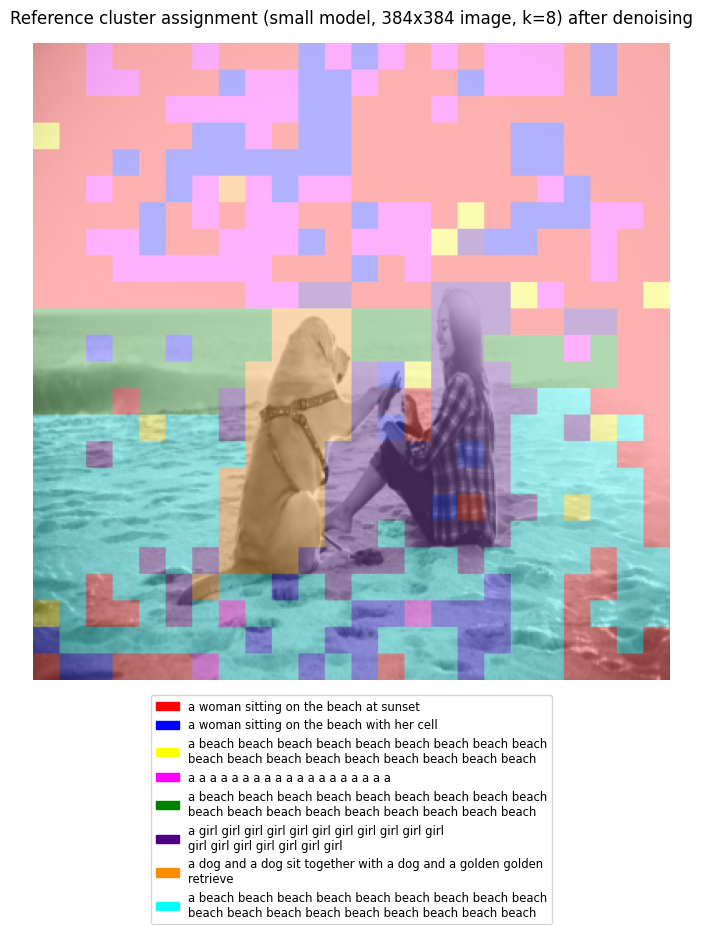

In [64]:
visualize_denoised_patch_clusters(
    majority_filter_denoised_cluster_label_map,
    decoded_denoised_cluster_descriptions,
    image,
    reference_set_name
)

### Noun Generation by filtering BLIP Decoder output from the clusters

In [65]:
import spacy
# from spacy.lang.en.examples import sentences

nlp = spacy.load("en_core_web_sm")
# doc = nlp(sentences[0])
# print(doc.text)
# for token in doc:
#     print(token.text, token.pos_, token.dep_)

# # now filter nouns from the document
# nouns = [token.text for token in doc if token.pos_ == "NOUN"]
# print(nouns)

doc = nlp('Ala has an awful cat that has some fur')
nouns = [token.text for token in doc if token.pos_ == "NOUN"]
print(nouns)

['cat', 'fur']


In [66]:
from nltk.corpus import wordnet

In [67]:
wordnet_lemmas = set(wordnet.all_lemma_names())

In [68]:
'hamburg' in wordnet_lemmas

True

### Forwarding Generated Nouns to the Segmentor

### Evaluation?